# CSC3831 Final Assessment - Part I: Data Engineering



In [48]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import requests
from io import StringIO
import urllib3
from sklearn.preprocessing import MinMaxScaler

urllib3.disable_warnings()

url = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv'
response = requests.get(url, verify=False)  # Disable SSL verification

# Load the content into pandas
houses_corrupted = pd.read_csv(StringIO(response.text))
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


Goal: To analyse and investigate datasets to summarise and visualise their main characteristics, often with visual methods.

In [7]:
houses_corrupted.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

In [6]:
houses_corrupted.head(10)

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,NaN,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,NaN,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
5,269700.0,4.0368,52.0,919.0,213.0,413.0,193.0,37.85,-122.25
6,299200.0,3.6591,52.0,2535.0,489.0,1094.0,514.0,37.84,-122.25
7,241400.0,3.1200,52.0,3104.0,687.0,1157.0,647.0,37.84,-122.25
8,226700.0,2.0804,42.0,2555.0,665.0,1206.0,595.0,37.84,-122.26
9,261100.0,3.6912,52.0,3549.0,707.0,1551.0,714.0,37.84,-122.25


Following gives an overview of the relationships between the features in the dataset. The diagonal shows the distribution of the data for each feature, helping us to identify the distribution of the data i.e., normal or skewed. If the distribution is skewed, we can apply transformations to make the data normal.

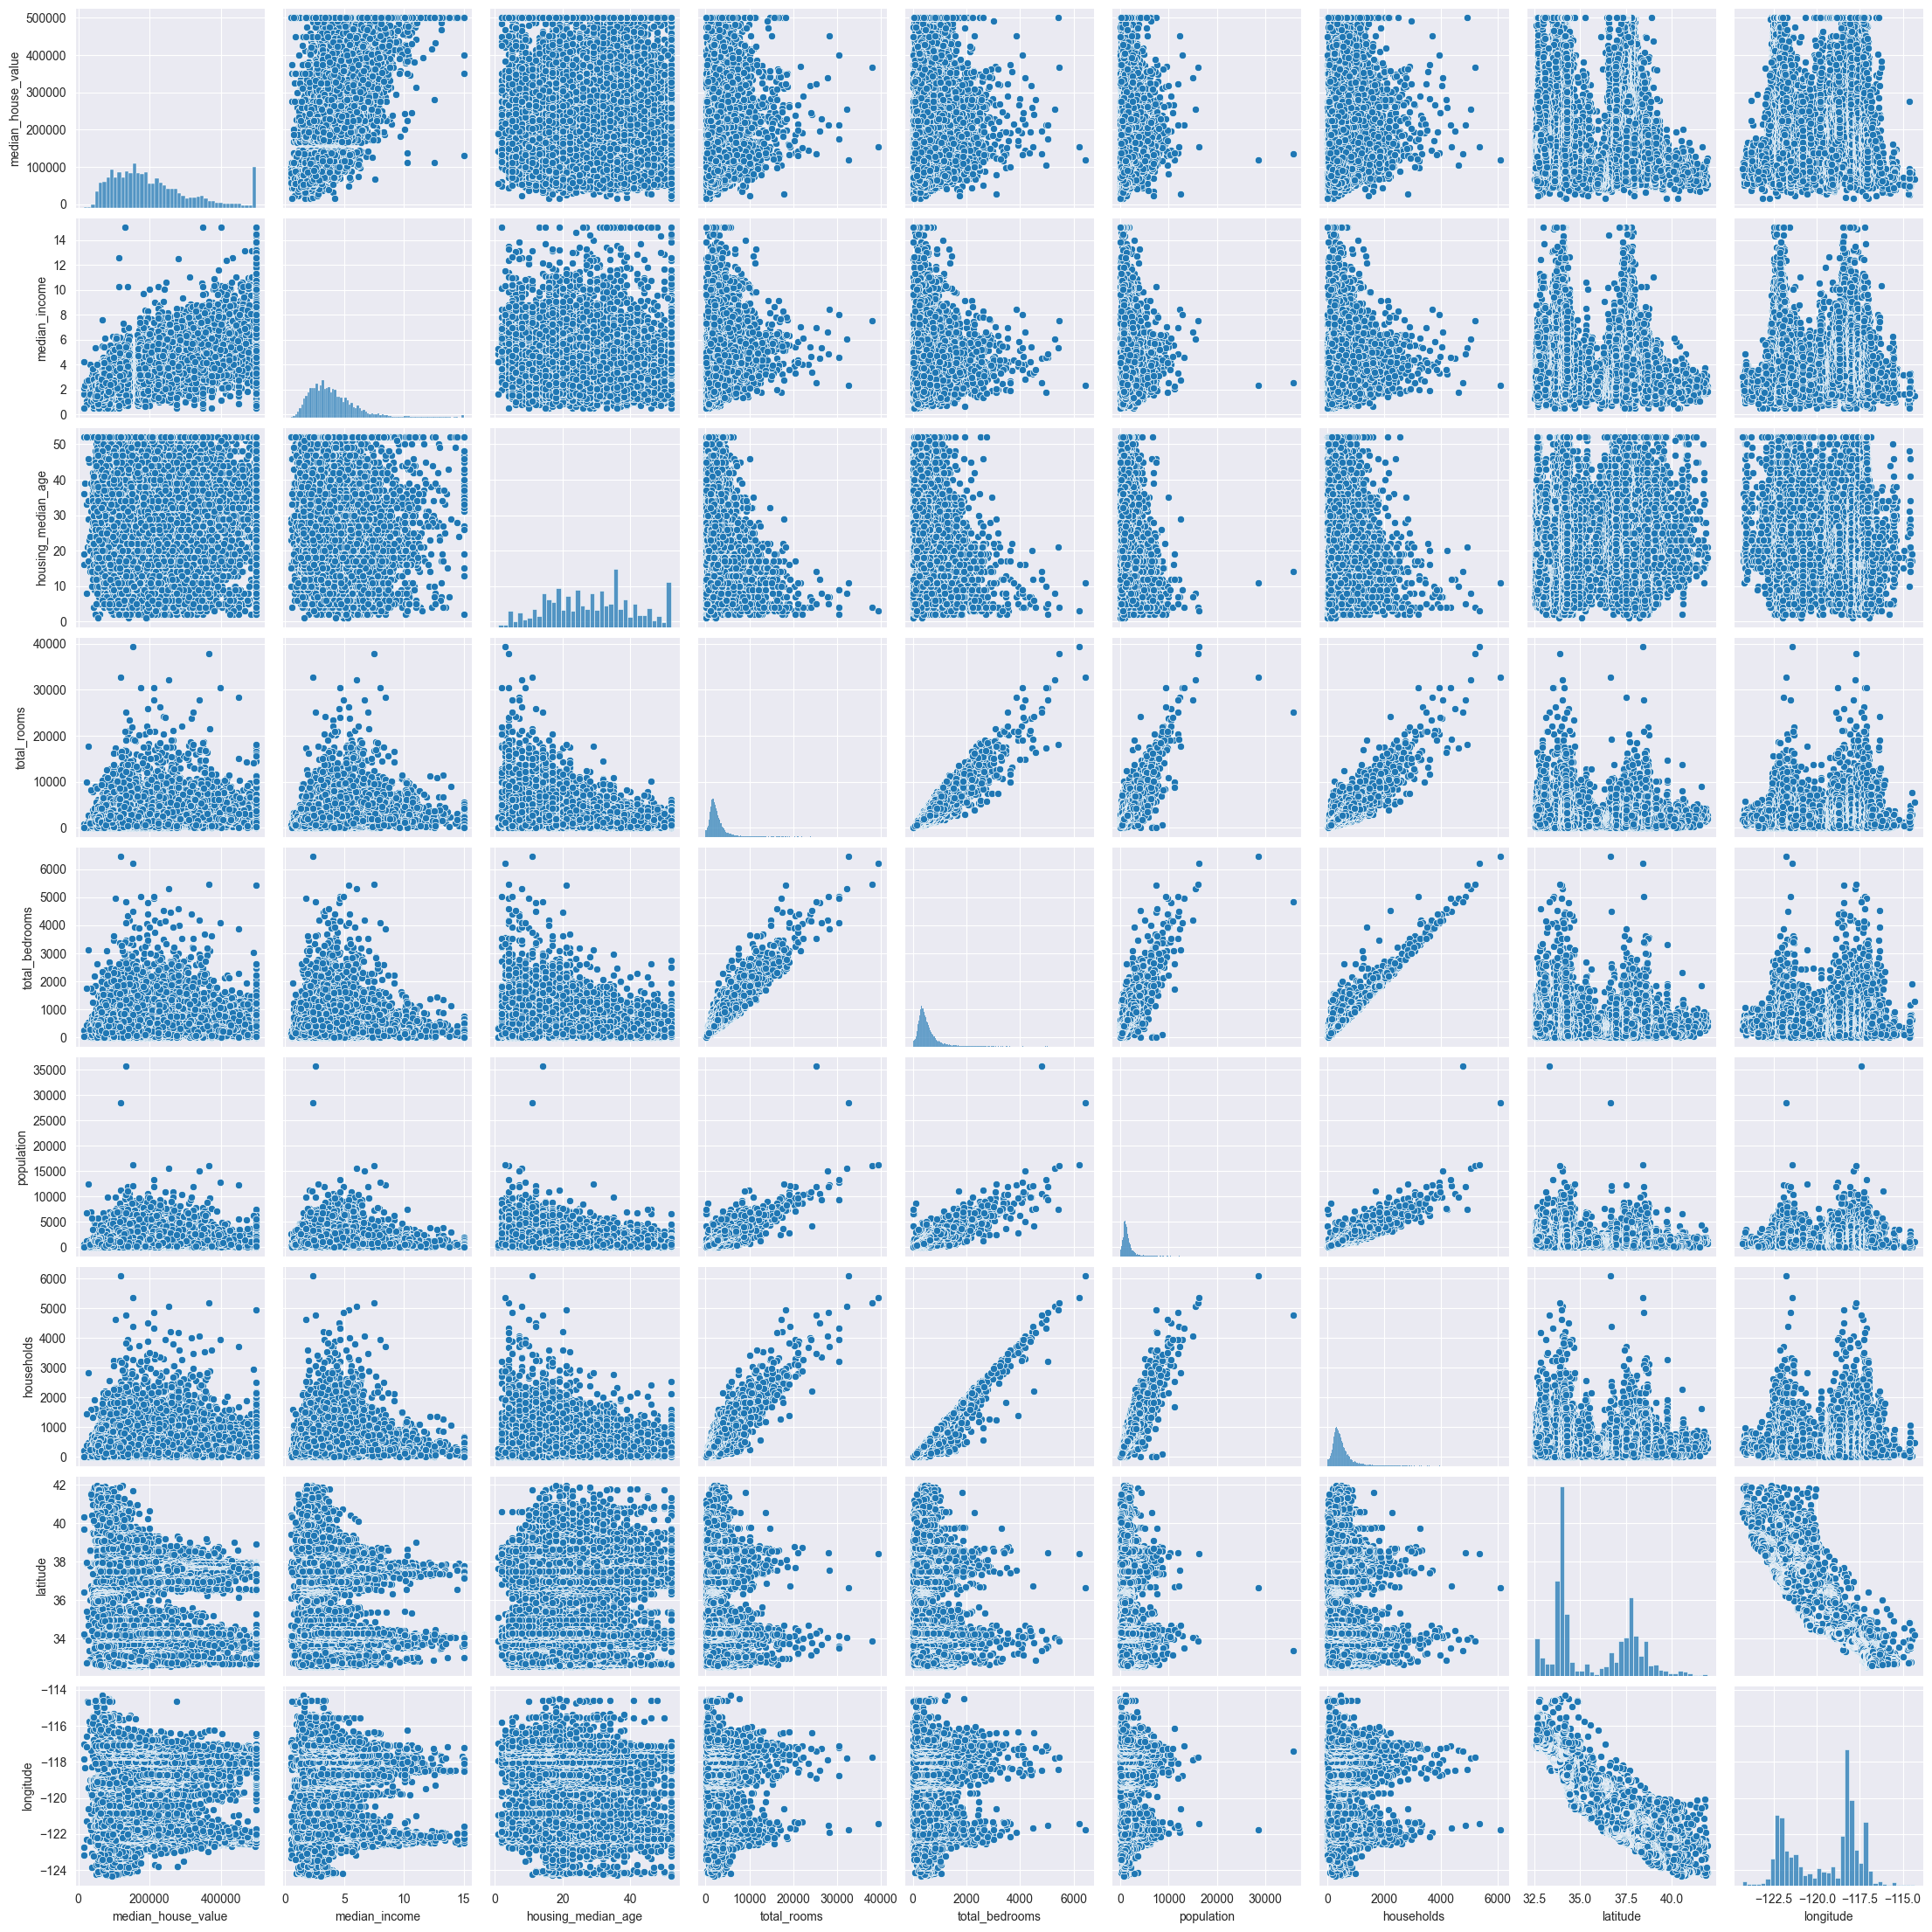

In [8]:
sns.pairplot(houses_corrupted)

<Axes: xlabel='median_house_value', ylabel='Density'>

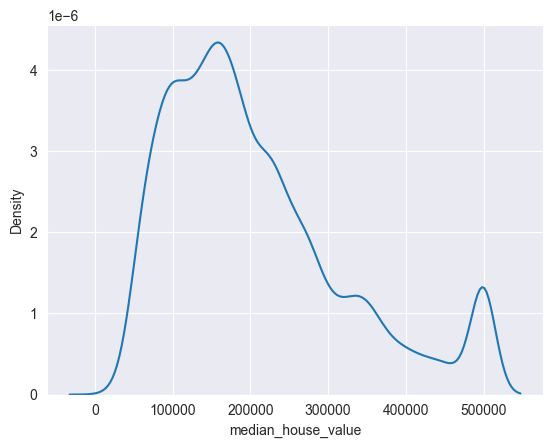

In [9]:
sns.kdeplot(houses_corrupted['median_house_value'])

<Axes: xlabel='median_income', ylabel='Density'>

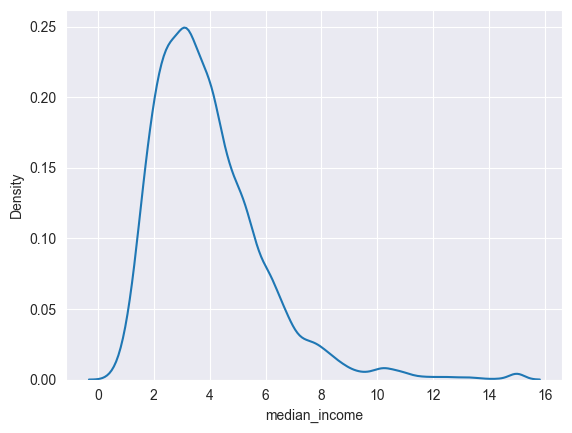

In [10]:
sns.kdeplot(houses_corrupted['median_income'])

<Axes: xlabel='total_rooms', ylabel='Density'>

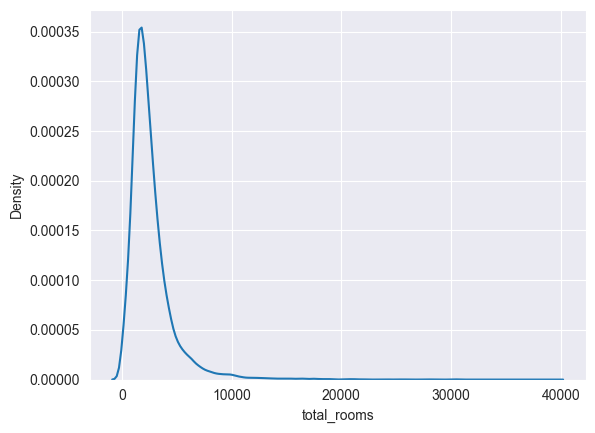

In [11]:
sns.kdeplot(houses_corrupted['total_rooms'])

<Axes: xlabel='housing_median_age', ylabel='Density'>

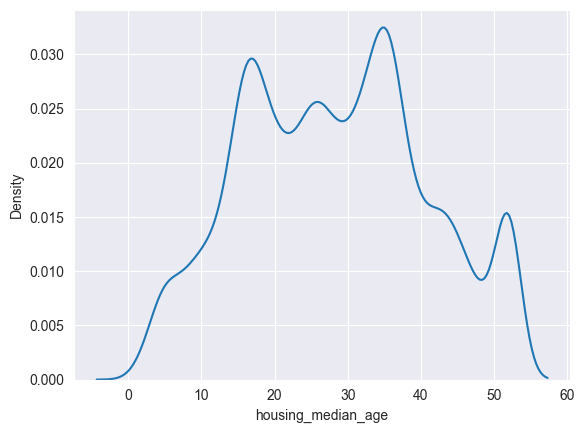

In [12]:
sns.kdeplot(houses_corrupted['housing_median_age'])

<Axes: xlabel='households', ylabel='Density'>

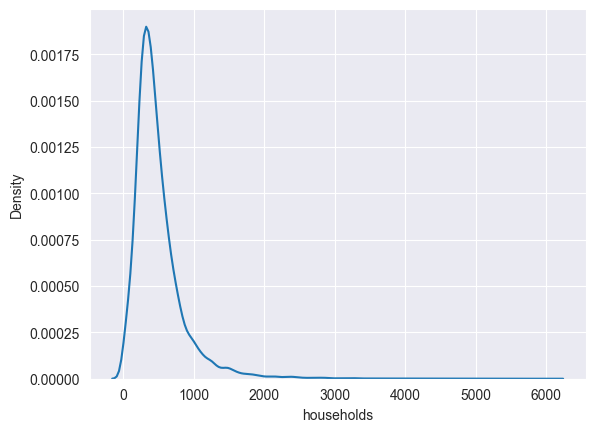

In [13]:
sns.kdeplot(houses_corrupted['households'])

<Axes: xlabel='total_bedrooms', ylabel='Density'>

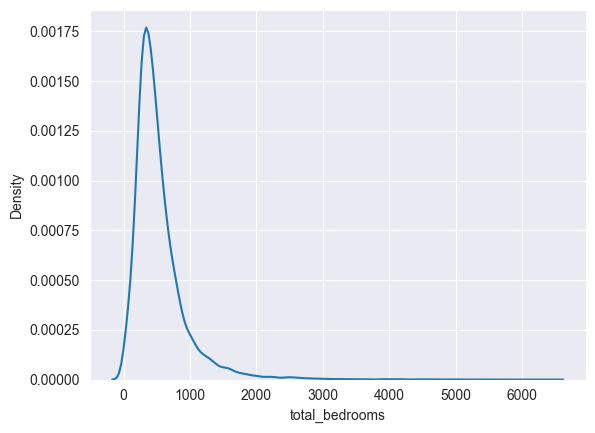

In [14]:
sns.kdeplot(houses_corrupted['total_bedrooms'])

<Axes: xlabel='population', ylabel='Density'>

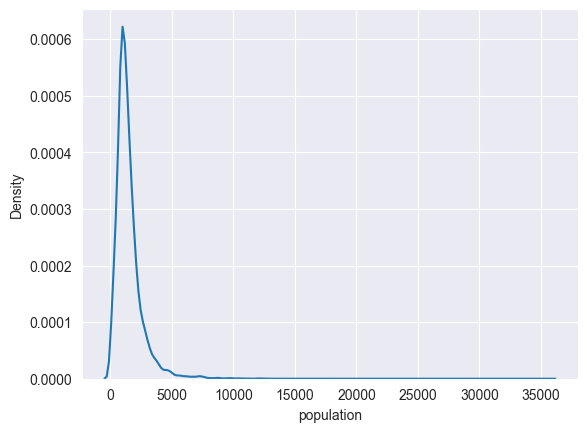

In [15]:
sns.kdeplot(houses_corrupted['population'])

<Axes: xlabel='latitude', ylabel='Density'>

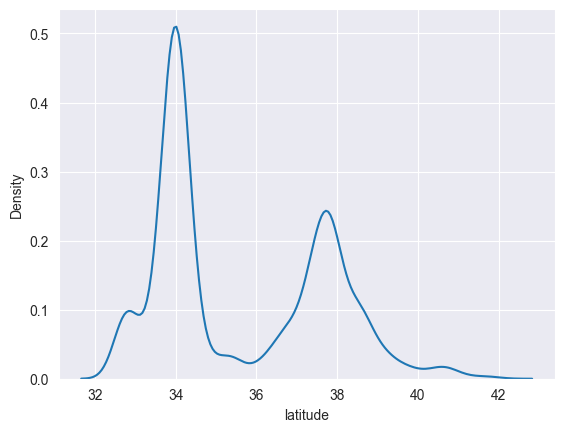

In [16]:
sns.kdeplot(houses_corrupted['latitude'])

<Axes: xlabel='longitude', ylabel='Density'>

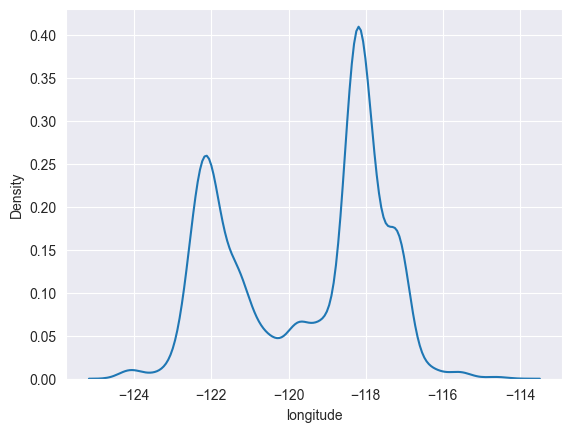

In [17]:
sns.kdeplot(houses_corrupted['longitude'])

In [18]:
houses_corrupted.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,18576.000000,18576.000000,20640.000000,20640.000000,18576.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.929958,28.324182,2635.763081,537.898014,1488.069283,499.539680,35.631861,-119.569704
std,115395.615874,1.964296,12.584914,2181.615252,421.247906,1170.585810,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.560300,18.000000,1447.750000,295.000000,839.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.572400,28.000000,2127.000000,435.000000,1227.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.870050,37.000000,3148.000000,647.000000,1803.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


As mean and standard deviation should be used for normal values, but median (50% percentile) and MAD should be used for skewed data.

In [35]:
houses_corrupted_MAD = pd.DataFrame(columns = houses_corrupted.columns)
MADS = []
for attribute in houses_corrupted.columns:
  mad = 1.483 * abs(houses_corrupted[attribute] - houses_corrupted[attribute].median()).median()
  MADS.append(mad)
houses_corrupted_MAD.loc[0] = MADS
print(houses_corrupted_MAD)

   median_house_value  median_income  housing_median_age  total_rooms  \
0            101437.2       1.660515              13.347     1181.951   

   total_bedrooms  population  households  latitude  longitude  
0         241.729     670.316     223.933   1.82409    1.89824  


Since the dataset is skewed, we cant correlate between the attributes. Let's try to fix the skew by applying a log transformation. Will play around with the outliers in the next section to completely fix the skew.

In [55]:
houses_corrupted_log = np.log(houses_corrupted+125)  # Adding 125 to avoid log(0) error
houses_corrupted_log.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,18576.000000,18576.000000,20640.000000,20640.000000,18576.000000,20640.000000,20640.000000,20640.000000
mean,12.085716,4.859155,5.029177,7.709283,6.357756,7.196336,6.305626,5.079027,1.606693
std,0.568649,0.015061,0.082283,0.661322,0.508377,0.623246,0.496320,0.013258,0.440421
min,9.624038,4.832305,4.836282,4.844187,4.836282,4.852030,4.836282,5.059679,-0.430783
25%,11.692953,4.848589,4.962845,7.360581,6.040255,6.871091,6.003887,5.068464,1.163151
50%,12.099739,4.856492,5.030438,7.719574,6.327937,7.209340,6.280396,5.070538,1.873339
75%,12.486919,4.866534,5.087596,8.093462,6.648985,7.564238,6.593045,5.091969,1.944481
max,13.122615,4.941643,5.176150,10.582663,8.790269,10.485899,8.733433,5.117694,2.369309


### 2. Outlier Identification [10]

- Utilise a statistical outlier detection approach (i.e., no KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches

Goal: To identify and remove outliers from the dataset.

68-95-99.7 rule: 68% of the data falls within 1 standard deviation, 95% within 2 standard deviations, and 99.7% within 3 standard deviations. So it is safe to assume that anything outside of 3 standard deviations is an outlier.

In [113]:
# Calculate the mean and standard deviation for each column
mean_values = houses_corrupted.mean()
std_dev_values = houses_corrupted.std()

# Define the outlier boundaries
lower_bound = mean_values - (3 * std_dev_values)
upper_bound = mean_values + (3 * std_dev_values)

# Flag outliers based on the 68-95-99.7 Rule
outliers = ((houses_corrupted < lower_bound) | (houses_corrupted > upper_bound))
outliers_only = houses_corrupted[outliers.any(axis=1)]
print("Outliers based on the 68-95-99.7 Rule:")
print(len(outliers_only))
outliers_only.head(10)

Outliers based on the 68-95-99.7 Rule:
854


,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
95,130000.0,2.0096,36.0,5329.0,2477.0,3469.0,2323.0,37.80,-122.26
104,335700.0,2.8406,34.0,5871.0,1914.0,2689.0,1789.0,37.81,-122.26
116,218500.0,2.4234,28.0,5022.0,1750.0,2558.0,1661.0,37.83,-122.25
131,392600.0,11.6017,18.0,1617.0,210.0,533.0,194.0,37.84,-122.19
283,371000.0,5.9849,22.0,12842.0,2048.0,4985.0,1967.0,37.79,-122.16
409,397000.0,10.0825,52.0,2003.0,250.0,658.0,244.0,37.90,-122.28
485,253600.0,1.6307,35.0,5161.0,1744.0,3276.0,1742.0,37.86,-122.26
508,143800.0,4.0018,14.0,7355.0,2408.0,3100.0,2051.0,37.84,-122.30
510,500001.0,11.8603,39.0,2492.0,310.0,808.0,315.0,37.82,-122.22
511,500001.0,13.4990,NaN,2991.0,335.0,1018.0,335.0,37.82,-122.22


Using a Robust Z-score method to identify outliers. The Robust Z-score is calculated by dividing the deviation from the median by the median absolute deviation (MAD). The MAD is a robust measure of the variability of a univariate sample of quantitative data.

In [42]:
# Calculate the median and MAD for each column
median_values = houses_corrupted.median()

# Calculate the robust Z-score for each element
robust_z_scores = 0.6745 * (houses_corrupted - median_values) / houses_corrupted_MAD

# Flag values where the robust Z-score is greater than 3
outliers_robust_z = (robust_z_scores.abs() > 3)
# Filter and print only the rows with True values (i.e., only the outliers)
outliers_robust_z_only = houses_corrupted[outliers_robust_z.any(axis=1)]
print("Outliers based on Robust Z-score:")
print(outliers_robust_z_only)

Outliers based on Robust Z-score:
Empty DataFrame
Columns: [median_house_value, median_income, housing_median_age, total_rooms, total_bedrooms, population, households, latitude, longitude]
Index: []


Using the Local Outlier Factor (LOF) algorithm to identify outliers. The LOF algorithm is an unsupervised outlier detection method that computes the local density deviation of a given data point with respect to its neighbors. 

I started with preprocessing the data by applying Min-Max scaling to normalize the logarithmic data.

In [119]:
#Log transformation followed by Min-Max scaling
houses_corrupted_cleaned = houses_corrupted.dropna()  # Drop rows with missing values
houses_log_transformed = np.log1p(houses_corrupted_cleaned+125)  # Apply log transformation
scaler = MinMaxScaler()  # Initialize scaler
houses_preprocessed = scaler.fit_transform(houses_log_transformed) # Apply scaling
houses_preprocessed = pd.DataFrame(houses_preprocessed, columns=houses_corrupted_cleaned.columns)  # Convert to DataFrame

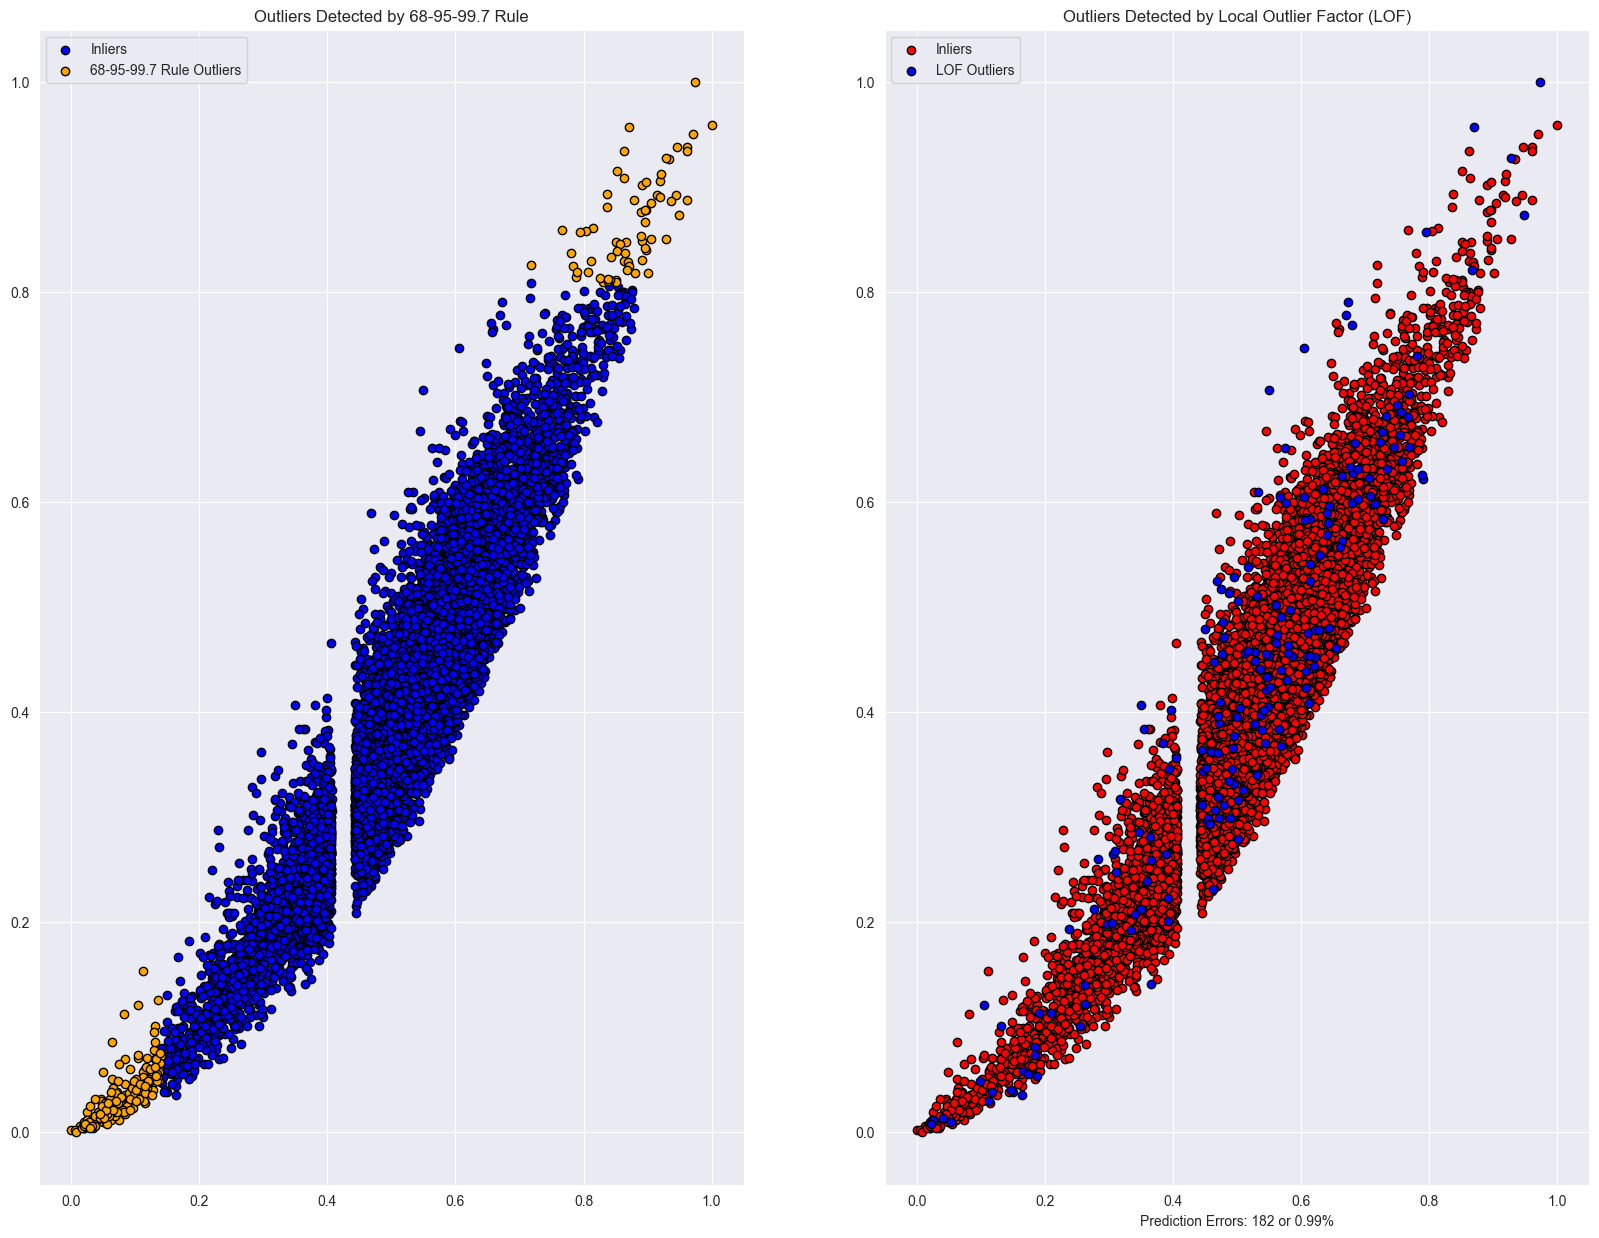

68-95-99.7 Rule - Number of Outliers Detected: 248
LOF - Number of Outliers Detected: 183


In [120]:
# Choose the two features to plot
feature_1 = houses_preprocessed.columns[3]  # replace with actual feature if different
feature_2 = houses_preprocessed.columns[4]  # replace with actual feature if different

# Calculate mean and standard deviation for the 68-95-99.7 rule
mean_1, std_1 = houses_preprocessed[feature_1].mean(), houses_preprocessed[feature_1].std()
mean_2, std_2 = houses_preprocessed[feature_2].mean(), houses_preprocessed[feature_2].std()

# Define the boundaries for outliers under 68-95-99.7 rule
outliers_1 = ((houses_preprocessed[feature_1] < mean_1 - 3 * std_1) | 
              (houses_preprocessed[feature_1] > mean_1 + 3 * std_1))
outliers_2 = ((houses_preprocessed[feature_2] < mean_2 - 3 * std_2) | 
              (houses_preprocessed[feature_2] > mean_2 + 3 * std_2))

# Combine conditions to identify outliers based on the 68-95-99.7 rule
rule_outliers = houses_preprocessed[outliers_1 | outliers_2]
rule_inliers = houses_preprocessed[~(outliers_1 | outliers_2)]

# Step 2: Apply Local Outlier Factor (LOF) for outlier detection
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(houses_preprocessed)
x_scores = clf.negative_outlier_factor_

# Identify the LOF-detected outliers and inliers
lof_outliers = houses_preprocessed[y_pred == -1]
lof_inliers = houses_preprocessed[y_pred == 1]
n_errors = sum((np.array(y_pred[-len(lof_outliers):] != -1)))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

# First Plot: 68-95-99.7 Rule Outliers
ax[0].scatter(rule_inliers[feature_1], rule_inliers[feature_2], c='blue', label="Inliers", edgecolor="k")
ax[0].scatter(rule_outliers[feature_1], rule_outliers[feature_2], c='orange', label="68-95-99.7 Rule Outliers", edgecolor="k")
ax[0].set_title("Outliers Detected by 68-95-99.7 Rule")
ax[0].legend()

# Second Plot: LOF Outliers
ax[1].scatter(lof_inliers[feature_1], lof_inliers[feature_2], c='red', label="Inliers", edgecolor="k")
ax[1].scatter(lof_outliers[feature_1], lof_outliers[feature_2], c='blue', label="LOF Outliers", edgecolor="k")
ax[1].set_xlabel("Prediction Errors: {n} or {per_n:.2f}%".format(n=n_errors, per_n=n_errors/len(lof_outliers)))
ax[1].set_title("Outliers Detected by Local Outlier Factor (LOF)")
ax[1].legend()

plt.show()

# Summary of results
print("68-95-99.7 Rule - Number of Outliers Detected:", len(rule_outliers))
print("LOF - Number of Outliers Detected:", len(lof_outliers))

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [ ]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

In [90]:

# Calculate the total number of rows
total_rows = len(houses_corrupted)

# Calculate the percentage of missing data for each column
missing_percentage = (houses_corrupted.isnull().sum() / total_rows) * 100

# Calculate the actual data percentage (100% - missing percentage)
actual_data_percentage = 100 - missing_percentage

# Combine both into a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Percentage': missing_percentage,
    'Actual Data Percentage': actual_data_percentage
})

# Display the results
print("Percentage of Missing Data vs. Actual Data:")
print(missing_summary)

Percentage of Missing Data vs. Actual Data:
                    Missing Percentage  Actual Data Percentage
median_house_value                 0.0                   100.0
median_income                     10.0                    90.0
housing_median_age                10.0                    90.0
total_rooms                        0.0                   100.0
total_bedrooms                     0.0                   100.0
population                        10.0                    90.0
households                         0.0                   100.0
latitude                           0.0                   100.0
longitude                          0.0                   100.0


### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation